In [1]:
import rasterio
from rasterio.transform import rowcol
from pyproj import Transformer

In [2]:
hennepin = rasterio.open("hennepin.tif")
green = rasterio.open("3.tif")


In [3]:
green.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': 0.0,
 'width': 9967,
 'height': 6451,
 'count': 1,
 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'),
 'transform': Affine(8.983152841195215e-05, 0.0, -93.69590110117751,
        0.0, -8.983152841195215e-05, 45.12911408595446)}

In [4]:
h_to_wgs84 = Transformer.from_crs(hennepin.crs, "EPSG:4326", always_xy=True)
h_from_wgs84 = Transformer.from_crs("EPSG:4326", hennepin.crs, always_xy=True)

g_to_wgs84 = Transformer.from_crs(green.crs, "EPSG:4326", always_xy=True)
g_from_wgs84 = Transformer.from_crs("EPSG:4326", green.crs, always_xy=True)

In [5]:
h_band = hennepin.read(1)
g_band = green.read(1)

First we define the bounding box, which is the same bounding box of the green space band.

Now we write some code that gets a random acre inside the bounding box.

In [6]:
import numpy as np

ACRE_EDGE_METERS = 63.6149353533
DEGREES_PER_METER = 8.983e-6

In [7]:
# Very green area: (np.float32(23.872145), np.float64(8.207601746116067)) OR 3668.7333532301463
# Very red area: (np.float32(0.0), np.float64(8.36240856826096)) OR 4282.99824673542

In [8]:
from rasterio.windows import Window

def generate_point():
    lat = np.random.uniform(
        green.bounds.bottom + ACRE_EDGE_METERS * DEGREES_PER_METER, 
        green.bounds.top
    )

    lon = np.random.uniform(
        green.bounds.left, 
        green.bounds.right - ACRE_EDGE_METERS * DEGREES_PER_METER
    )
    return lat, lon

def generate_window(region, from_wsg84, lon, lat):
    x, y = from_wsg84.transform(lon, lat)
    row_min, col_min = rowcol(region.transform, x, y)

    # Bottom right for green
    x, y = from_wsg84.transform(lon + ACRE_EDGE_METERS * DEGREES_PER_METER, lat - ACRE_EDGE_METERS * DEGREES_PER_METER)
    row_max, col_max = rowcol(region.transform, x, y)
    window = Window(col_off=col_min, row_off=row_min, width=col_max-col_min+1, height=row_max-row_min+1)

    return window

In [9]:
data = {
    "heat": [],
    "green": [],
    "lat": [],
    "lon": []
}

vals = 0

while vals < 5000:
    
    # Generate random coordinates
    lat, lon = generate_point()

    # Get windows
    green_window = generate_window(green, g_from_wgs84, lon, lat)
    heat_window = generate_window(hennepin, h_from_wgs84, lon, lat)

    green_data = green.read(1, window=green_window)
    heat_data = hennepin.read(1, window=heat_window)
    heat_data = np.nan_to_num(heat_data, nan=0.0, posinf=0.0, neginf=0.0)

    if not (np.isfinite(heat_data.sum()) and np.isfinite(green_data.sum())):
        print("GOT ILLEGAL VALUE")
        continue
    print("Here!")
    vals += 1
    data["heat"].append(heat_data.sum())
    data["green"].append(green_data.sum())
    data["lat"].append(lat)
    data["lon"].append(lon)

Here!
Here!
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
Here!
Here!
Here!
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
Here!
Here!
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
Here!
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
Here!
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
Here!
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
Here!
GOT ILLEGAL VALUE
Here!
GOT ILLEGAL VALUE
Here!
Here!
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
Here!
Here!
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
Here!
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
Here!
Here!
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT 

/Users/propoop/Code/greenalysis/greenalysis/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
Here!
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
Here!
GOT ILLEGAL VALUE
Here!
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
Here!
Here!
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
Here!
GOT ILLEGAL VALUE
Here!
GOT ILLEGAL VALUE
Here!
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
Here!
Here!
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
Here!
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
Here!
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
Here!
GOT ILLEGAL VALUE
Here!
Here!
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
Here!
Here!
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
Here!
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGA

In [10]:
import pandas as pd

df = pd.DataFrame(data)

In [17]:
df.describe()

/Users/propoop/Code/greenalysis/greenalysis/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,heat,green,lat,lon
count,5.000000e+03,5000.000000,5000.000000,5000.000000
mean,inf,16.041151,44.757764,-93.254093
std,inf,5.166590,0.168905,0.286699
min,2.904539e+03,0.626025,44.550678,-93.695878
25%,3.149932e+03,12.898062,44.619032,-93.534934
50%,3.606177e+03,16.129064,44.701658,-93.250769
75%,3.768834e+03,19.344265,44.865605,-92.985736
max,1.790000e+308,35.329247,45.128933,-92.801309


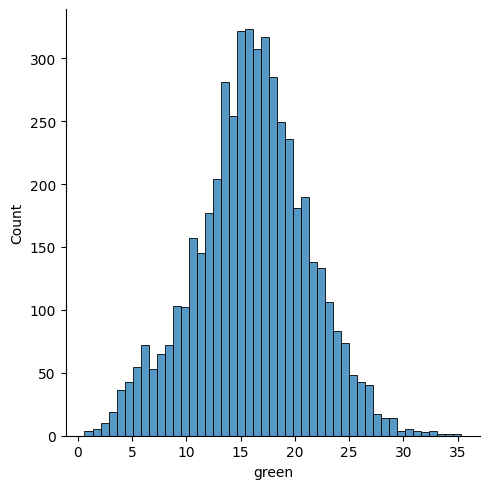

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

standardized = df

# standardized['heat'] = np.log(df['heat'])
sns.displot(data=df, x='green')

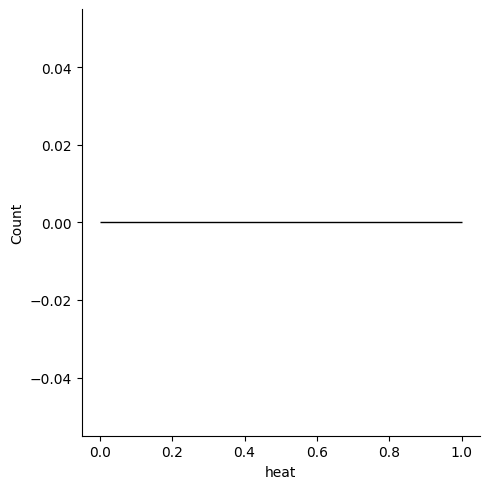

In [13]:
ndf = df[df['heat'] < 10]
import seaborn as sns
sns.displot(data=ndf, x="heat")

In [19]:
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split

# Convert data to arrays
X = np.array(df["green"]).reshape(-1, 1)
y = np.array(df["heat"])

# Remove bad values
mask = np.isfinite(X).flatten() & np.isfinite(y)
X = X[mask]
y = y[mask]

Since the $p$-value is below 0.05 and the coefficient for x1 is negative, it follows that there is a negative correlation between the amount of green space and heat. The goal is to now minimize the MSE by introducing various regresion models of various complexities.

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures

for deg in range(10):
    kf = KFold(n_splits=10, shuffle=True)
    res = 0
    for (train_index, test_index) in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Fit OLS model
        poly = PolynomialFeatures(1)
        X_poly = poly.fit_transform(X_train)
        X_polyy = poly.fit_transform(X_test)
        model = LinearRegression()

        results = model.fit(X_poly, y_train)

        y_pred = results.predict(X_polyy)
        res += mean_squared_error(y_test, y_pred)
    print(f"{deg} | Average MSE: {res / 10}")

/Users/propoop/Code/greenalysis/greenalysis/.venv/lib/python3.13/site-packages/sklearn/utils/_array_api.py:757: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)


ValueError: Input contains infinity or a value too large for dtype('float32').

In [21]:
i = 49
y_pred[i], y_test[i]

NameError: name 'y_pred' is not defined

<Axes: xlabel='lon', ylabel='lat'>

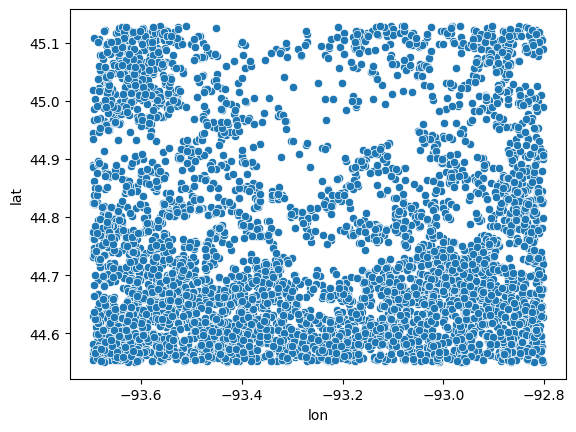

In [22]:
sns.scatterplot(df, x="lon", y="lat")

In [27]:
df['heat'] = np.log(df['heat'])

In [28]:
cluster1 = df[df['heat'] > 8.3]
cluster2 = df[(df['heat'] >= 8.125) & (df['heat'] <= 8.3)]
cluster3 = df[df['heat'] < 8.125]

In [29]:
df[df['heat'] < 8.3]

,heat,green,lat,lon
0,8.053603,12.370387,44.730034,-92.918113
1,8.036557,19.515022,44.892679,-92.998180
2,8.062219,13.931317,44.592782,-93.364470
4,8.038468,14.994914,45.067558,-93.539042
5,8.051586,14.909855,44.721889,-93.610385
...,...,...,...,...
4995,8.253939,15.327778,44.666533,-93.355392
4996,8.020925,20.551939,44.597722,-93.477241
4997,8.174251,8.670027,44.716393,-93.067579
4998,7.986559,28.219854,44.834993,-92.894807


<Axes: xlabel='lon', ylabel='lat'>

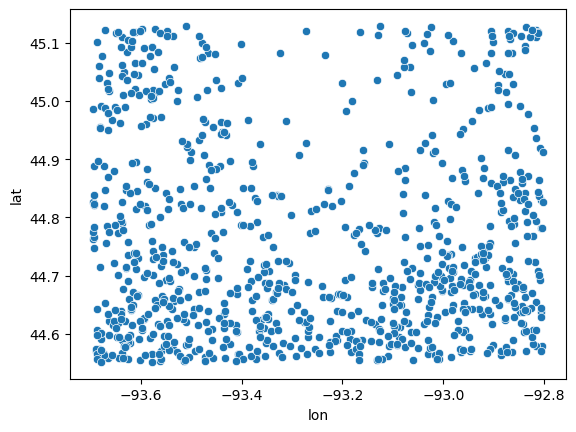

In [30]:
sns.scatterplot(cluster1, x="lon", y="lat")

<Axes: xlabel='lon', ylabel='lat'>

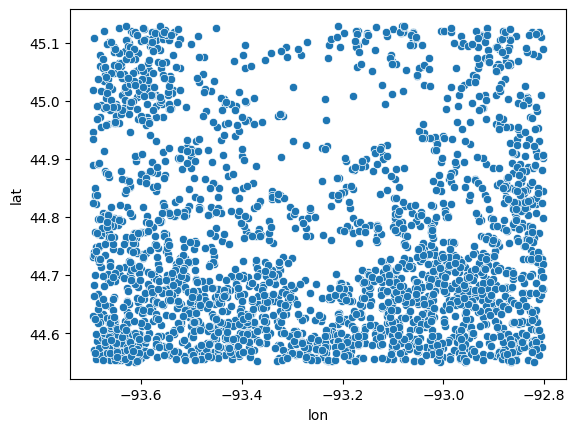

In [31]:
sns.scatterplot(cluster2, x="lon", y="lat")

<Axes: xlabel='lon', ylabel='lat'>

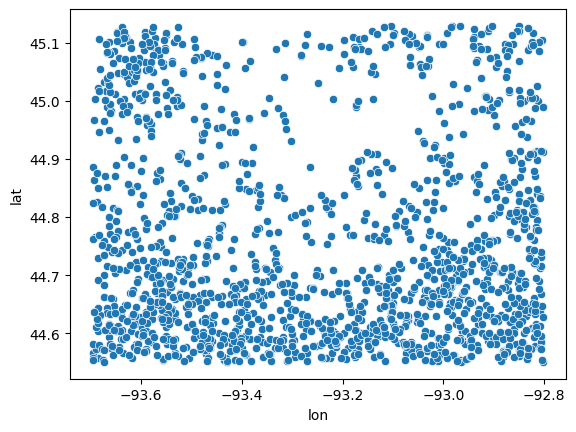

In [32]:
sns.scatterplot(cluster3, x="lon", y="lat")

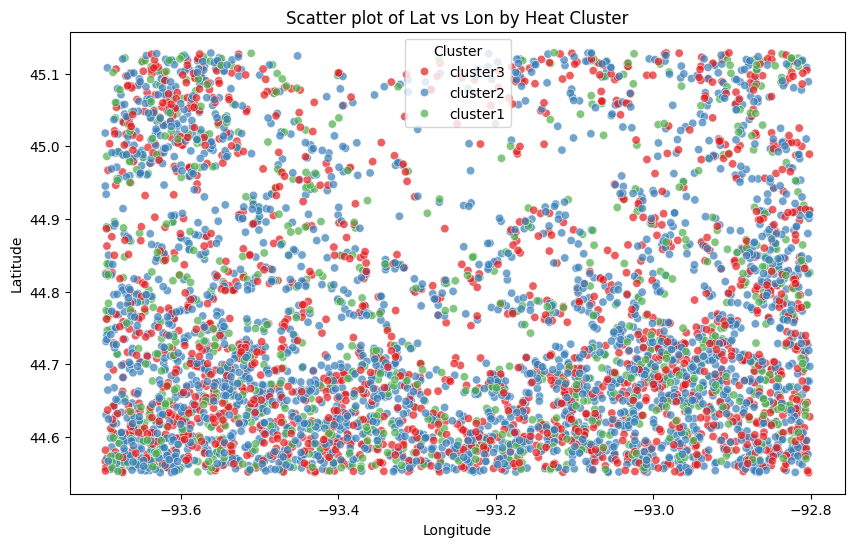

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example: assume your df already exists
# Assign cluster labels
df['cluster'] = pd.cut(df['heat'],
                       bins=[-float('inf'), 8.125, 8.3, float('inf')],
                       labels=['cluster3', 'cluster2', 'cluster1'])

# Scatter plot of lat vs lon colored by cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='lon', y='lat', hue='cluster', palette='Set1', alpha=0.7)
plt.title("Scatter plot of Lat vs Lon by Heat Cluster")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title='Cluster')
plt.show()


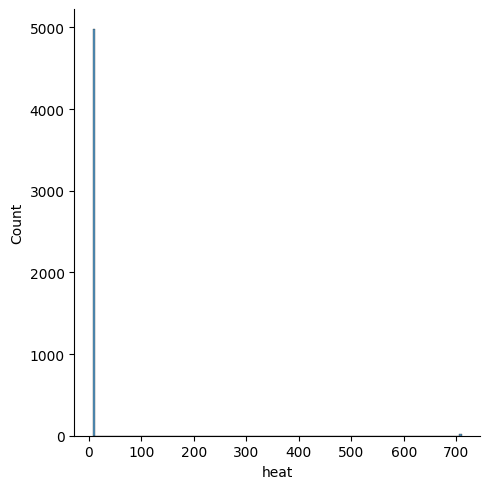

In [ ]:
ndf = df[df['heat'] < 10]

sns.displot(data=ndf, x="heat")